# WEIGHT ESTIMATION - TEST EFFICIENT NET Research Project

In [92]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# import libraries
import torch
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from torchvision import datasets
from skimage import io, transform
from torch.utils.data import DataLoader
import time
import os
from PIL import Image
from torchvision import transforms
import logging
from datetime import datetime
import copy
import time
from sklearn.model_selection import KFold
from tqdm import tqdm
import random
import os
from sklearn.model_selection import train_test_split

In [94]:
# Get the seconds since epoch
secondsSinceEpoch = time.time()
# Convert seconds since epoch to struct_time
timeObj = time.localtime(secondsSinceEpoch)

time = str(timeObj.tm_mday)+ '-' + str(timeObj.tm_mon) +'-'+ str(timeObj.tm_year)+'-'+str(timeObj.tm_hour)+'_'+str(timeObj.tm_min)
print(time)

15-4-2020-13_14


In [95]:
# Path of Folders
content = '/content/drive/My Drive/new-frames/'
labels_csv = '/content/drive/My Drive/weights.csv'
train_path = content + "train"
test_path = content + "test"
validation_path = content + "validation"

weights=pd.read_csv(labels_csv)
weights = weights['WEIGHT'].values

print('Start initialization logging file')
logging.basicConfig(filename='app_' + time + '.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s')
logging.warning('Initialized File')

# Instantiate visualizer
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Efficient-Net')

Start initialization logging file


## Efficient Net


In [0]:
# Source: https://github.com/lukemelas/EfficientNet-PyTorch
# Version: 0.4.0
"""
This file contains helper functions for building the model and for loading model parameters.
These helper functions are built to mirror those in the official TensorFlow implementation.
"""

import re
import math
import collections
from functools import partial
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo


########################################################################
############### HELPERS FUNCTIONS FOR MODEL ARCHITECTURE ###############
########################################################################


# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate',
    'num_classes', 'width_coefficient', 'depth_coefficient',
    'depth_divisor', 'min_depth', 'drop_connect_rate', 'image_size'])


# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'stride', 'se_ratio'])


# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


def relu_fn(x):
    """ Swish activation function """
    return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)

class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]]*2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""
    def __init__(self, in_channels, out_channels, kernel_size, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


class Identity(nn.Module):
    def __init__(self,):
        super(Identity, self).__init__()

    def forward(self, input):
        return input


########################################################################
############## HELPERS FUNCTIONS FOR LOADING MODEL PARAMS ##############
########################################################################


def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """

    @staticmethod
    def _decode_block_string(block_string):
        """ Gets a block through a string notation of arguments. """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            stride=[int(options['s'][0])])

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """
        Decodes a list of string notations to specify blocks inside the network.

        :param string_list: a list of strings, each string is a notation of block
        :return: a list of BlockArgs namedtuples of block args
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """
        Encodes a list of BlockArgs to a list of strings.

        :param blocks_args: a list of BlockArgs namedtuples of block args
        :return: a list of strings, each string is a notation of block
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet(width_coefficient=None, depth_coefficient=None, dropout_rate=0.2,
                 drop_connect_rate=0.2, image_size=None, num_classes=1000):
    """ Creates a efficientnet model. """

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        # data_format='channels_last',  # removed, this is always true in PyTorch
        num_classes=num_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
        image_size=image_size,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


# url_map = {
#     'efficientnet-b0': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b0-355c32eb.pth',
#     'efficientnet-b1': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b1-f1951068.pth',
#     'efficientnet-b2': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b2-8bb594d6.pth',
#     'efficientnet-b3': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b3-5fb5a3c3.pth',
#     'efficientnet-b4': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b4-6ed6700e.pth',
#     'efficientnet-b5': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b5-b6417697.pth',
#     'efficientnet-b6': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b6-c76e70fd.pth',
#     'efficientnet-b7': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b7-dcc49843.pth',
# }

url_map = {
    'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth',
}

def load_pretrained_weights(model, model_name, load_fc=True):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    state_dict = model_zoo.load_url(url_map[model_name])
    if load_fc:
        model.load_state_dict(state_dict)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        res = model.load_state_dict(state_dict, strict=False)
        assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
    print('Loaded pretrained weights for {}'.format(model_name))

class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block

    Args:
        block_args (namedtuple): BlockArgs, see above
        global_params (namedtuple): GlobalParam, see above

    Attributes:
        has_se (bool): Whether the block contains a Squeeze and Excitation layer.
    """

    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # skip connection and drop connect

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Expansion phase
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Output phase
        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)

    def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = relu_fn(self._bn0(self._expand_conv(inputs)))
        x = relu_fn(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(relu_fn(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x


class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods

    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks

    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')

    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._dropout = self._global_params.dropout_rate
        self._fc = nn.Linear(out_channels, self._global_params.num_classes)

    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = relu_fn(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = relu_fn(self._bn1(self._conv_head(x)))

        return x

    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """

        # Convolution layers
        x = self.extract_features(inputs)

        # Pooling and final linear layer
        x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        if self._dropout:
            x = F.dropout(x, p=self._dropout, training=self.training)
        x = self._fc(x)
        return x

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return EfficientNet(blocks_args, global_params)

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000):
        model = EfficientNet.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000))
        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name, also_need_pretrained_weights=False):
        """ Validates model name. None that pretrained weights are only available for
        the first four models (efficientnet-b{i} for i in 0,1,2,3) at the moment. """
        num_models = 4 if also_need_pretrained_weights else 8
        valid_models = ['efficientnet_b'+str(i) for i in range(num_models)]
        if model_name.replace('-','_') not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))

    

## Optimizer and Cost Function
Declaration of the optimizer and of the cost function.

In [0]:
def get_optimizer(net, lr):
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  return optimizer

def get_cost_function():
  cost_function = torch.nn.MSELoss()
  return cost_function

## New KFold Cross Validation
This is an improvement of the section before since this one creates dinamically the minibatch for the computatation of a single fold


In [98]:
weights=pd.read_csv(labels_csv)
train_IDs, test_IDs = train_test_split(weights, test_size=0.1, random_state=42)

# Check len of IDs
print('Train:', len(train_IDs))
print('Test:', len(test_IDs))

Train: 92
Test: 11


In [0]:
def generateDatasetIDS(list, root_folder = "/content/drive/My Drive/frames/"):
  """
  Return a list with all the image paths relative to those IDs
  """
  test_list = []
  for id in list:
    #print("Id:", id)
    for root, dirs, files in os.walk(root_folder + str(id) ):
        for filename in files:
            #print("\t", str(id) + "/" + filename)
            if('.png' in filename):
              add_file = str(id) + "/" + filename
              test_list.append(add_file)
  return test_list

class CustomListDataset(torch.utils.data.Dataset):

    def __init__(self, images_list, df_weights, root_dir,transform = None):
        """
        Args:
            images_list(list): list with IDs into the dataset
            root_dir(string): directory with all the images
            df_weights(pd_dataframe): dataframe with all the weights of the people
            transform: trasform operation for images
        """
        self.images_list = images_list
        self.root_dir = root_dir
        self.df_weights = df_weights
        self.df_weights = self.df_weights['WEIGHT'].values
        self.transform = transform

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images_list[idx])
        image = Image.open(img_name)
        image = image.convert(mode='RGB')
        if(self.transform is not None):
            image = self.transform(image)
        frame_name = self.images_list[idx].split("/")
        id = int(frame_name[0]) 
        labels = self.df_weights[id]
        labels = np.float(labels)
        return image, torch.as_tensor(labels)

transform = transforms.Compose([
    # you can add other transformations in this list
    #transforms.Resize((299,299), interpolation=2),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.ToTensor()
])


In [0]:
# save checkpoint function
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, filename + "best")

def adjust_learning_rate(optimizer, epoch, learning_rate):
    """Sets the learning rate to the initial LR decayed by 10 every 100 epochs"""
    lr = learning_rate * (0.1 ** (epoch // 50))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [101]:
import time
seed_torch(11)
device='cuda:0'
learning_rate = 0.01
momentum_ = 0.9
weight_decay = 1e-4

num_epochs = 100
splits = 3
batch_size = 32

model = EfficientNet.from_pretrained('efficientnet-b5')
model._fc = nn.Linear(2048, 1)
print(model)


optimizer = get_optimizer(model, learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), learning_rate,
#                                 momentum=momentum_,
#                                 weight_decay=weight_decay)

loss_fn = get_cost_function()

kf = KFold(n_splits=splits, shuffle=True)
fold = 1

# best accuracy to be stored
best_acc1 = 0

"""# Add values to plots
tb.save_value('Loss/train_loss', visualization_name, 0, train_loss)
tb.save_value('Loss/test_loss', visualization_name, 0, test_loss)

# Update plots 
tb.flush_line(visualization_name)
"""
global_epoch = 0

for train_index, test_index in kf.split(train_IDs):
  #print("TRAIN:", len(train_index), "TEST:", len(test_index))
  model.cuda()
  train_images_list = generateDatasetIDS(train_index,"/content/drive/My Drive/frames/")
  train = CustomListDataset(images_list = train_images_list, df_weights = weights, root_dir="/content/drive/My Drive/frames/", transform = transform)
  trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

  test_images_list = generateDatasetIDS(test_index,"/content/drive/My Drive/frames/")
  test = CustomListDataset(images_list = test_images_list, df_weights = weights, root_dir="/content/drive/My Drive/frames/", transform = transform)
  validationloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

  print(f'Len Train (in batch): {len(trainloader)}')
  print(f'Len validation (in batch): {len(validationloader)}')

  print(f'Fold {fold}')
  fold += 1
  
  for epoch in range(num_epochs):
      start_time = time.time()
      
      # adjust learning rate
      curr_learnig = adjust_learning_rate(optimizer, global_epoch, learning_rate)
      global_epoch += 1

      model.train()
      avg_loss = 0.
      cumulative_loss = 0.
      samples = 0
      for i, (x_batch, y_batch) in enumerate(trainloader):
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          y_batch = y_batch.view(-1,1)
          y_pred = model(x_batch)
          loss = loss_fn(y_pred, y_batch)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          samples+=x_batch.shape[0]
          cumulative_loss += loss.item()
      avg_loss = cumulative_loss / samples
      
      model.eval()
      avg_val_loss = 0.
      cumulative_val_loss = 0.
      val_samples = 0
      with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(validationloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_batch = y_batch.view(-1,1)
            y_pred = model(x_batch)
            cumulative_val_loss += loss_fn(y_pred, y_batch).item()
            val_samples += x_batch.shape[0]
        avg_val_loss = cumulative_val_loss / val_samples
          #valid_preds_fold[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]

      elapsed_time = time.time() - start_time 

      writer.add_scalar('training loss',
                            avg_loss,
                            global_epoch)
      
      writer.add_scalar('validation loss',
                            avg_val_loss,
                            global_epoch)

      acc1 = avg_val_loss

      # remember best acc@1 and save checkpoint
      is_best = acc1 > best_acc1
      best_acc1 = max(acc1, best_acc1)

      print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s , lr={:.4f}'.format(
          epoch + 1, num_epochs, avg_loss, avg_val_loss, elapsed_time, curr_learnig))
      
      # save every 20 epoches
      # if epoch%20:
      #   save_checkpoint({
      #       'epoch': epoch + 1,
      #       'fold': fold,
      #       'state_dict': model.state_dict(),
      #       'best_acc1': best_acc1,
      #       'optimizer' : optimizer.state_dict(),
      #   }, is_best, "/content/drive/My Drive/model/effic_lr01_200epoch-fold" + str(fold) + "epochnum" + str(epoch+1)+ ".pth.tar")
  

Loaded pretrained weights for efficientnet-b5
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2

*Test* the final Results:


In [0]:
# Save the network parameters
torch.save(model.state_dict(), "/content/drive/My Drive/model/efficientnet-b5_100_3fold.pt") 


In [103]:
test_list = generateDatasetIDS(test_IDs.ID,"/content/drive/My Drive/frames/")
print(len(test_list))
test_custom = CustomListDataset(images_list = test_list, df_weights = weights, root_dir="/content/drive/My Drive/frames/", transform = transform)
test_final_loader = torch.utils.data.DataLoader(test_custom, batch_size=64, shuffle=False, num_workers=2)

print(len(test_final_loader))
print(len(test_final_loader.dataset))

predicted_label = list()
real_label = list()

#Set the network in eval mode
model.eval()
with torch.no_grad():
  # Loop over the dataset
  for batch_idx, (inputs, targets) in enumerate(test_final_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    #print('inputs', inputs.shape)

    targets = targets.to(device)
    #print('targets', targets.shape)

    # Forward pass
    outputs = model.forward(inputs)
    
    #print('Out:',outputs.shape)
    
    arr1 = outputs.data.cpu().numpy()
    arr2 = targets.data.cpu().numpy()

    predicted_label.extend(arr1)
    real_label.extend(arr2)


357
6
357


In [104]:
#print (predicted_label)

import numpy as np
predicted_label = np.array(predicted_label,dtype=int)
real_label = np.array(real_label, dtype=int)
#print(predicted_label)

pred_label_list = list()
for x in np.nditer(predicted_label):
  #print(x)
  pred_label_list.append(x)

real_label_list = list()
for x in np.nditer(real_label):
  real_label_list.append(x)

print(len(pred_label_list))

357


<class 'numpy.ndarray'>


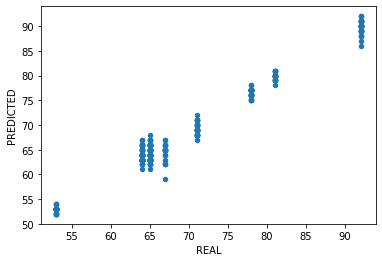

In [105]:
import numpy as np
import pandas as pd

'''real_label, predicted_label'''

print(type(real_label))

df = pd.DataFrame({'REAL': np.asarray(real_label_list), 'PREDICTED':np.asarray(pred_label_list)})
df.plot('REAL', 'PREDICTED', kind='scatter')

In [106]:
#See unique real values 
print(df.PREDICTED.unique())

#Check the average value of the predicted labels
df.groupby('REAL').mean()

[68 69 71 70 67 72 80 81 79 78 64 66 62 63 65 76 77 75 88 90 86 89 91 92
 87 61 59 53 52 54]


,PREDICTED
REAL,
53,52.942857
64,63.852941
65,64.140000
67,64.368421
71,69.314286
78,76.564103
81,79.869565
92,89.789474


In [107]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def r2_rmse( g ):
    r2 = r2_score( g.REAL, g.PREDICTED)
    count = len(g.REAL)
    mse = mean_squared_error( g['REAL'], g['PREDICTED'] ) 
    rmse = np.sqrt( mean_squared_error( g['REAL'], g['PREDICTED'] ) ) 
    return pd.Series( dict( count = int(count), r2 = r2, rmse = rmse, mse = mse ) )

print("Global:", r2_rmse(df))

#Statistics over REAL value
df.groupby( 'REAL' ).apply( r2_rmse ).reset_index()


Global: count    357.000000
r2         0.971334
rmse       1.767272
mse        3.123249
dtype: float64


,REAL,count,r2,rmse,mse
0,53,35.0,0.0,0.478091,0.228571
1,64,68.0,0.0,1.224745,1.500000
2,65,100.0,0.0,1.624808,2.640000
3,67,19.0,0.0,3.276712,10.736842
4,71,35.0,0.0,2.035401,4.142857
5,78,39.0,0.0,1.617215,2.615385
6,81,23.0,0.0,1.383128,1.913043
7,92,38.0,0.0,2.544344,6.473684


In [0]:
df.to_csv(r'./result.csv', index = False)
